# **Israel Elections Data Analysis - Final Report**

### **Import modules**

In [69]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import math
import operator
import os
import io
from matplotlib import pyplot as plt
import numpy.matlib as mtl
import copy
import random
import statsmodels.api as sm
import seaborn as sns
import holoviews as hv
import plotly.graph_objects as go
import plotly.express as pex
import scipy
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import warnings
import random
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import nnls
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

%matplotlib inline

### **Import data**

In [70]:
# Mount drive in google colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Loading elections 2020 elections data:
from google.colab import files
uploaded = files.upload()


Saving Eshkol Hevrati Calcali.csv to Eshkol Hevrati Calcali (1).csv
Saving votes per ballot 2019a.csv to votes per ballot 2019a (1).csv
Saving votes per ballot 2019b.csv to votes per ballot 2019b (1).csv
Saving votes per ballot 2020.csv to votes per ballot 2020 (1).csv
Saving votes per city 2019a.csv to votes per city 2019a (1).csv
Saving votes per city 2019b.csv to votes per city 2019b (1).csv
Saving votes per city 2020.csv to votes per city 2020 (1).csv


In [72]:
df_2020_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='סמל ישוב')
df_2019a_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2019a.csv']),  encoding = 'iso-8859-8', index_col='סמל ישוב')
df_2019b_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2019b.csv']),  encoding = 'iso-8859-8', index_col='סמל ישוב')
df_2020_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2019a_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2019a.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2019b_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2019b.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')

**:בניית מילון לשמות המפלגות**

In [73]:
party_dict = { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
              "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה" }

par_names = list(party_dict.values())

In [74]:
# Change dataframe to include unique index for each ballot. From Harel Cain
def adapt_df(df, parties, include_no_vote=False, ballot_number_field_name=None):
    df['ballot_id'] = df['סמל ישוב'].astype(str) + '__' + df[ballot_number_field_name].astype(str)
    df_yeshuv = df.index  # new: keep yeshuv
    df = df.set_index('ballot_id')
    eligible_voters = df['בזב']
    total_voters = df['מצביעים']
    df = df[parties]
    df['ישוב'] = df_yeshuv  # new: keep yeshuv
    df = df.reindex(sorted(df.columns), axis=1)
    if include_no_vote:
        df['לא הצביעו'] = eligible_voters - total_voters
    return df

In [75]:
def heatmap_plot(m_hat, str_title, y,x):
  fig, ax = plt.subplots(figsize =(9,7))
  sns.heatmap(m_hat ,xticklabels=x, yticklabels=y, annot=True)
  ax.set_xlabel("Parties 2020")
  ax.set_ylabel("Parties 2019")
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right",rotation_mode="anchor")
  ax.set_title(str_title)

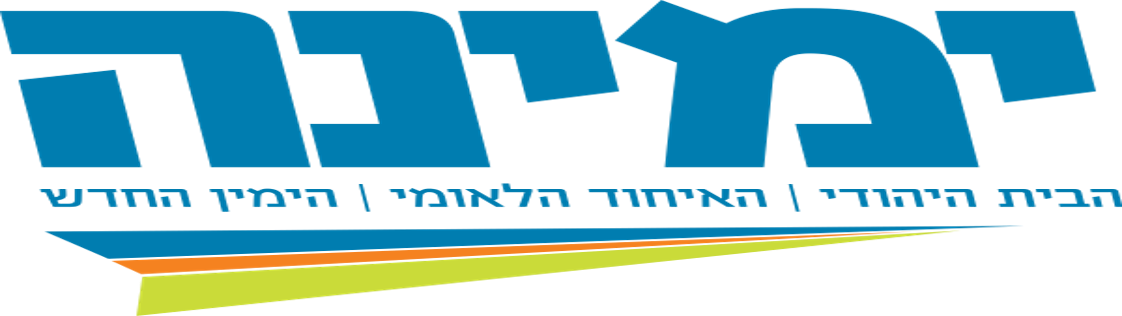

# **א. רקע**

מופיע בהרחבה בPDF

# **ב. שינויים שעברה מפלגת ימינה מבחירות אפריל 2019 ועד בחירות מרץ 2020**

בבחירות אפריל 2019 מפלגת ימינה עדיין לא הוקמה, והמפלגות המרכיבות אותה רצו בנפרד- איחוד מפלגות הימין (הבית היהודי+האיחוד הלאומי), עוצמה יהודית עם מפלגת הימין החדש.

 לאחר מכן בבחירות ספטמבר 19 המפלגות אוחדו ללא עוצמה יהודית ורצו כמפלגה אחת- מפלגת ימינה שרצה באותה מתכונת גם בבחירות מרץ 20.



**השינויים בהרכב המפלגה בשלוש מערכות הבחירות**

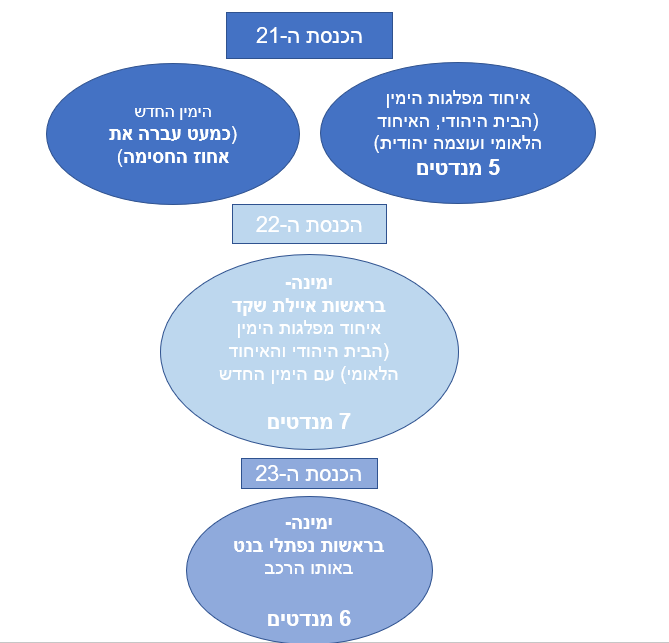

# **ג. אחוז ההצבעה למפלגה מקרב המצביעים הפוטנציאליים**

In [76]:
df_2019a_city_raw['טב'] = df_2019a_city_raw['טב'] + df_2019a_city_raw['נ']
df_2019a = df_2019a_city_raw[df_2019a_city_raw.columns[5:]] # removing "metadata" columns
df_2019b = df_2019b_city_raw[df_2019b_city_raw.columns[6:]]
df_2020 = df_2020_city_raw[df_2020_city_raw.columns[6:]]  # removing "metadata" columns

שיעור הצבעה כללי במערכות הבחירות

In [77]:
V2019a = (df_2019a_city_raw['כשרים'].sum())/(df_2019a_city_raw['בזב'].sum())
V2019b = (df_2019b_city_raw['כשרים'].sum())/(df_2019b_city_raw['בזב'].sum())
V2020 = (df_2020_city_raw['כשרים'].sum())/(df_2020_city_raw['בזב'].sum())
[V2019a , V2019b, V2020]

[0.6797246380720691, 0.6942035148855821, 0.7112785718215071]

חישוב אחוזי ההצבעה פוטנציאליים (עבור 100%)

In [78]:
Vi2020 = df_2020_city_raw['כשרים'].div(df_2020_city_raw['בזב'])
df_fix2020 = df_2020.div(Vi2020 , axis = 'rows')

Vi2019a = df_2019a_city_raw['כשרים'].div(df_2019a_city_raw['בזב'])
df_fix2019a = df_2019a.div(Vi2019a , axis = 'rows')

Vi2019b = df_2019b_city_raw['כשרים'].div(df_2019b_city_raw['בזב'])
df_fix2019b = df_2019b.div(Vi2019b , axis = 'rows')

חישוב אחוזי ההצבעה של ימינה בפועל, מתוך המצביעים הפוטנציאליים

In [79]:
ratio_fix2019a = df_2019a["טב"].sum()/df_fix2019a["טב"].sum()
ratio_fix2019b = df_2019b["טב"].sum()/df_fix2019b["טב"].sum()
ratio_fix2020 = df_2020["טב"].sum()/df_fix2020["טב"].sum()
[ratio_fix2019a, ratio_fix2019b, ratio_fix2020]

[0.7459633828784789, 0.7574923613421481, 0.7800063835041752]

In [80]:
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

fix2019a = (parties_votes_percents(df_fix2019a,0)).loc['טב']
fix2019b = (parties_votes_percents(df_fix2019b,0)).loc['טב']
fix2020 = (parties_votes_percents(df_fix2020,0)).loc['טב']

real2019a = (parties_votes_percents(df_2019a,0)).loc['טב']
real2019b = (parties_votes_percents(df_2019b,0)).loc['טב']
real2020 = (parties_votes_percents(df_2020,0)).loc['טב']

In [81]:
fix = [fix2019a, fix2019b, fix2020]
real = [real2019a, real2019b, real2020]

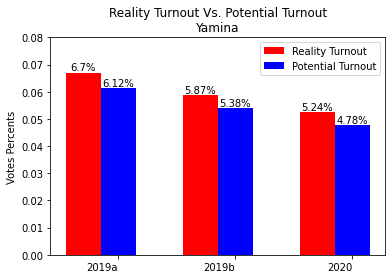

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe41fda64e0>)

In [82]:
def bar_plot(df1, df2, legend1, legend2, main_t):
    
    width = 0.3
    n = 3
    fig, ax = plt.subplots()  # plt.subplots()
    dat1_bar = ax.bar(np.arange(n)- width, df1, width, color='r')
    dat2_bar = ax.bar(np.arange(n) , df2, width, color='b')


    ax.set_ylabel('Votes Percents')
    #ax.set_xlabel('Parties Names')
    ax.set_title(main_t )
    ax.legend((dat1_bar[0], dat2_bar[0]), (legend1,legend2))
    ax.set_xticks(np.arange(n))
    plt.setp(ax.get_xticklabels(), ha="right",rotation_mode="anchor")
    ax.set_xticklabels(list(['2019a', '2019b', '2020']))
    plt.ylim(0,0.08)

    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height,'{}%'.format(((height*100).round(2))) ,
                ha='center', va='bottom')
    plt.show()

    return fig, ax

bar_plot(real,fix,"Reality Turnout",'Potential Turnout','Reality Turnout Vs. Potential Turnout\nYamina')

# **ד. פיזור חברתי וגיאוגרפי של ההצבעות למפלגה**

מחיקת המעטפות החיצוניות

In [83]:
df_2020_city_raw = df_2020_city_raw.drop(['מעטפות חיצוניות'], axis=0)
df_2019a_city_raw = df_2019a_city_raw.drop(['מעטפות חיצוניות'], axis=0)
df_2019b_city_raw = df_2019b_city_raw.drop(['מעטפות חיצוניות'], axis=0)

In [84]:
# Create a merged data frame by using the pandas join commend:
eshkol_hevrati_calcali  = pd.read_csv("Eshkol Hevrati Calcali.csv")
df_2020 = df_2020_city_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019

df_2020.rename(columns={"סמל ישוב":"set_code"}, inplace=True)
join_result = pd.merge(eshkol_hevrati_calcali,df_2020,on="set_code",how="inner")    ## inner join

In [85]:
party_join = join_result[['eco_level','טב']]

yamina_socio = []
sd_data = []
sum_par = sum(party_join["טב"])
for j in range(1,11): 
  esh_data = pd.DataFrame(party_join.loc[party_join["eco_level"] == j])
  sd_data.append(np.std(np.array(esh_data[esh_data.columns[1]]/sum_par)))
  yamina_socio.append(sum(esh_data[esh_data.columns[1]])/sum_par)
yamina_socio, sd_data = pd.Series(yamina_socio), pd.Series(sd_data)
yamina_socio.index, sd_data.index = [1,2,3,4,5,6,7,8,9,10] , [1,2,3,4,5,6,7,8,9,10] 

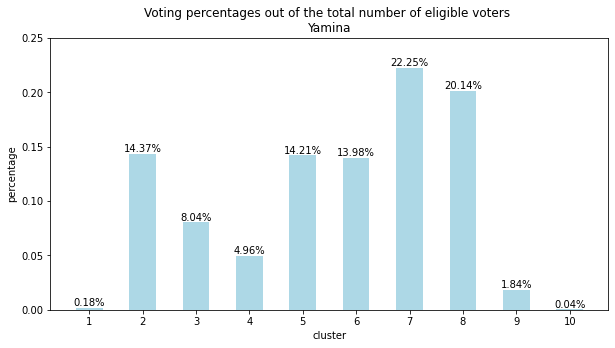

In [86]:
fig, ax = plt.subplots(figsize = (10,5))    
width = 0.5 # the width of the bars 
ind = np.arange(len(yamina_socio))  # the x locations for the groups
ax.bar(ind, list(yamina_socio), width, color="lightblue")
ax.set_xticks(np.arange(10))
ax.set_xticklabels(yamina_socio.index)
plt.ylim(0,0.25)
ax.set_ylabel('percentage')
ax.set_xlabel('cluster')
ax.set_title('Voting percentages out of the total number of eligible voters \nYamina' )

rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height,'{}%'.format(((height*100).round(2))) ,
            ha='center', va='bottom')

In [87]:
eco_78 = join_result.where((join_result['eco_level'] == 7) | (join_result['eco_level'] == 8))
eco_78 = eco_78.sort_values(ascending=False,by = "טב")
eco_78_top = eco_78[party_dict]
eco_ratio_78 = pd.DataFrame(eco_78_top.sum()/eco_78_top.sum().sum()).loc["טב"][0]
eco_78["potential gap"] = (eco_ratio_78 * eco_78["כשרים"]) - eco_78["טב"]

In [88]:
top_10_strong = eco_78.sort_values(ascending=True,by = "potential gap").head(10)['name']
top_10_strong 

1118             פתח תקווה
1134            גבעת שמואל
1149    מודיעין-מכבים-רעות
1145                 רעננה
1130                 אלקנה
1117                רחובות
153             נוף איילון
547               חשמונאים
139             נווה דניאל
546             כפר אדומים
Name: name, dtype: object

In [89]:
top_10_weak = eco_78.sort_values(ascending=False,by = "potential gap").head(10)['name']
top_10_weak

1141     תל אביב-יפו
1129     ראשון לציון
1112            חיפה
1110           חולון
1146         הרצלייה
1157       הוד השרון
1133          רמת גן
1156         גבעתיים
1139         כפר סבא
1111    קריית ביאליק
Name: name, dtype: object

# **ה. PCA:**

In [90]:
df_2020 = df_2020_ballot_raw[df_2020_ballot_raw.columns[10:]]
df_2020 = df_2020.div(df_2020.sum(axis=1),axis=0)

In [91]:
pca = PCA(n_components=2)  # define PCA object
X_pca = pca.fit_transform(df_2020)  # Perform PCA transformation

PCA - first plot

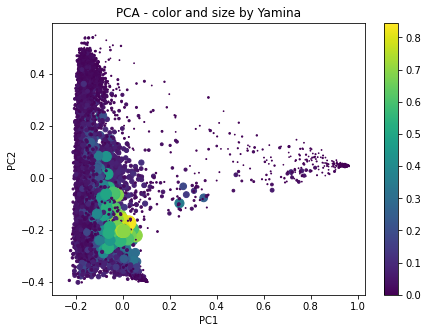

In [92]:
color = df_2020['טב']
size = [n/max(color)*200 for n in color]
fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = color, cmap='viridis', s = size)
ax.set_title('PCA - color and size by Yamina')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(sc)
plt.show()

In [93]:
df_2019a_ballot_raw['טב'] = df_2019a_ballot_raw['טב'] + df_2019a_ballot_raw['נ']
df_2019a_ballot_raw = df_2019a_ballot_raw.drop(["נ"], axis=1)
df_2019a_ballot_raw = df_2019a_ballot_raw.rename(columns =  {'מספר קלפי' : 'קלפי'})

In [94]:
join_result = pd.merge(df_2019a_ballot_raw, df_2019b_ballot_raw,on=["סמל ישוב","קלפי"], suffixes=("_a","_b"))
df_2020_ballot_raw_sf=df_2020_ballot_raw.add_suffix("_c")
df_2020_ballot_raw_sf = df_2020_ballot_raw_sf.rename(columns =  {'סמל ישוב_c' :"סמל ישוב"})
df_2020_ballot_raw_sf = df_2020_ballot_raw_sf.rename(columns =  {'קלפי_c' :"קלפי"})
join_result = join_result.merge(df_2020_ballot_raw_sf,on=["סמל ישוב","קלפי"])

In [95]:
per_2019a = join_result["טב_a"].div(join_result["כשרים_a"])
per_2019b = join_result["טב_b"].div(join_result["כשרים_b"])
per_2020 = join_result["טב_c"].div(join_result["כשרים_c"])

PCA plot -diff 2019a to 2019b

In [96]:
df_2020 = join_result[join_result.columns[96:]]
df_2020 = df_2020.div(df_2020.sum(axis=1),axis=0)

In [97]:
pca = PCA(n_components=2)  # define PCA object
X_pca = pca.fit_transform(df_2020)  # Perform PCA transformation

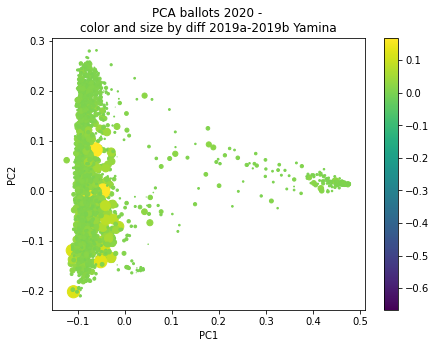

In [98]:
diff_per = list(map(operator.sub,per_2019b,per_2019a))
size = [n/max(diff_per)*200 for n in diff_per]
color = diff_per

fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = color, cmap='viridis', s = size)
ax.set_title('PCA ballots 2020 - \ncolor and size by diff 2019a-2019b Yamina')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(sc)
plt.show()

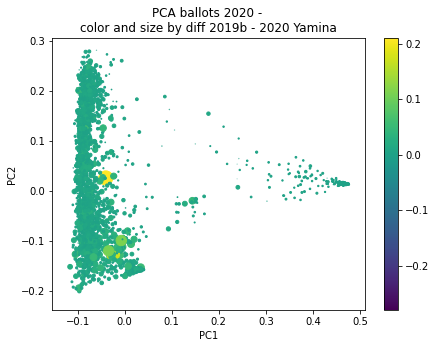

In [99]:
diff_per = list(map(operator.sub,per_2020,per_2019b))
size = [n/max(diff_per)*200 for n in diff_per]
color = diff_per

fig, ax = plt.subplots(figsize=(7,5))
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = color, cmap='viridis', s = size)
ax.set_title('PCA ballots 2020 - \ncolor and size by diff 2019b - 2020 Yamina')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(sc)
plt.show()

# **ו. מעבר קולות מימינה ומהמפלגות המרכיבות אותה  למפלגות אחרות**

נטען מחדש את הקובץ של 2019 כדי להפריד בין המפלגות שמרכיבות את ימינה

In [100]:
df_2019a_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2019a.csv']),  encoding = 'iso-8859-8', index_col='סמל ישוב')
df_2019a_ballot_raw = df_2019a_ballot_raw.rename(columns =  {'מספר קלפי' : 'קלפי'})
df_2019a_ballot_raw["ודעם"] = df_2019a_ballot_raw["דעם"] + df_2019a_ballot_raw["ום"]
df_2019a_ballot_raw['אמת'] = df_2019a_ballot_raw["אמת"] +  df_2019a_ballot_raw["נר"] +  df_2019a_ballot_raw["מרצ"]


הכנת מילונים למערכות הבחירות

In [101]:
par_dict19a ={ "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "איחוד מפלגות הימין" , "נ" : "הימין החדש", "לא הצביעו" : "לא הצביעו"}

par_dict20 = { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה", "לא הצביעו" : "לא הצביעו"}
par_dict19b=  { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה",  "כף": "עוצמה יהודית","לא הצביעו" : "לא הצביעו"}
rev_names19a = [name[::-1] for name in list(par_dict19a.values())]
rev_names19b = [name[::-1] for name in list(par_dict19b.values())]
rev_names20 = [name[::-1] for name in list(par_dict20.values())]

In [102]:
col19a = list(par_dict19a.keys()) +["שם ישוב"]+ ['קלפי']
col19b = list(par_dict19b.keys()) +["שם ישוב"]+ ['קלפי']
col20 = list(par_dict20.keys()) +["שם ישוב"]+ ['קלפי']

df_2019a_ballot_raw['לא הצביעו'] = df_2019a_ballot_raw["בזב"]- df_2019a_ballot_raw["כשרים"]
df_2019b_ballot_raw['לא הצביעו'] = df_2019b_ballot_raw["בזב"]- df_2019b_ballot_raw["כשרים"]
df_2020_ballot_raw['לא הצביעו'] = df_2020_ballot_raw["בזב"]- df_2020_ballot_raw["כשרים"]

b2019a = df_2019a_ballot_raw[col19a]
b2019b = df_2019b_ballot_raw[col19b]
b2020 = df_2020_ballot_raw[col20]


In [103]:
u_ap_sep = pd.merge(b2019a, b2019b, how='inner', on= ["סמל ישוב", "קלפי"])
u_ap_mar = pd.merge(b2019a, b2020, how='inner', on= ["סמל ישוב", "קלפי"])
u_sep_mar = pd.merge(b2019b, b2020, how='inner', on= ["סמל ישוב", "קלפי"])

In [104]:
top_ap_sep= u_ap_sep[u_ap_sep.columns[:10]]
top_sep_ap= u_ap_sep[u_ap_sep.columns[12:22]]
top_ap_mar= u_ap_mar[u_ap_mar.columns[:10]]
top_mar_ap= u_ap_mar[u_ap_mar.columns[12:21]]
top_sep_mar= u_sep_mar[u_sep_mar.columns[:10]]
top_mar_sep= u_sep_mar[u_sep_mar.columns[12:21]]

 **יצירת מטריצות מעבר**

אילוצי חיוביות- OLS רגיל


In [105]:
m_19b_19a = (np.linalg.inv(np.transpose(top_ap_sep).dot(top_ap_sep))).dot(np.transpose(top_ap_sep).dot(top_sep_ap))
m_19b_19a = pd.DataFrame(m_19b_19a,index = par_dict19a, columns = par_dict19b)
m_19b_19a = m_19b_19a.div(m_19b_19a.sum(axis=1),axis=0)

m_20_19a = (np.linalg.inv(np.transpose(top_ap_mar).dot(top_ap_mar))).dot(np.transpose(top_ap_mar).dot(top_mar_ap))
m_20_19a = pd.DataFrame(m_20_19a, index = par_dict19a, columns = par_dict20)
m_20_19a = m_20_19a.div(m_20_19a.sum(axis=1),axis=0)

m_20_19b = (np.linalg.inv(np.transpose(top_sep_mar).dot(top_sep_mar))).dot(np.transpose(top_sep_mar).dot(top_mar_sep))
m_20_19b = pd.DataFrame(m_20_19b,index = par_dict19b, columns = par_dict20)
m_20_19b = m_20_19b.div(m_20_19b.sum(axis=1),axis=0)

nnls

In [106]:
m_19b_19a_nnls = np.zeros((top_ap_sep.shape[1], top_sep_ap.shape[1]))

for i in range(top_sep_ap.shape[1]):
    sol, r2 = scipy.optimize.nnls(top_ap_sep, top_sep_ap.iloc[:, i])
    m_19b_19a_nnls[:,i] = sol

m_19b_19a_nnls[m_19b_19a_nnls<0.005] = 0
m_19b_19a_nnls= pd.DataFrame(data=m_19b_19a_nnls, index=par_dict19a.keys(), columns =par_dict19b.keys() )
m_19b_19a_nnls = m_19b_19a_nnls.div(m_19b_19a_nnls.sum(axis=1),axis=0)


In [107]:
m_20_19b_nnls = np.zeros((top_sep_mar.shape[1], top_mar_sep.shape[1]))

for i in range(top_mar_sep.shape[1]):
    sol, r2 = scipy.optimize.nnls(top_sep_mar, top_mar_sep.iloc[:, i])
    m_20_19b_nnls[:,i] = sol

m_20_19b_nnls[m_20_19b_nnls<0.005] = 0
m_20_19b_nnls= pd.DataFrame(data=m_20_19b_nnls, index=par_dict19b.keys(), columns =par_dict20.keys() )
m_20_19b_nnls = m_20_19b_nnls.div(m_20_19b_nnls.sum(axis=1),axis=0)


In [108]:
m_20_19a_nnls = np.zeros((top_ap_mar.shape[1], top_mar_ap.shape[1]))

for i in range(top_mar_ap.shape[1]):
    sol, r2 = scipy.optimize.nnls(top_ap_mar, top_mar_ap.iloc[:, i])
    m_20_19a_nnls[:,i] = sol

m_20_19a_nnls[m_20_19a_nnls<0.005] = 0
m_20_19a_nnls= pd.DataFrame(data=m_20_19a_nnls, index=par_dict19a.keys(), columns =par_dict20.keys() )
m_20_19a_nnls = m_20_19a_nnls.div(m_20_19a_nnls.sum(axis=1),axis=0)

יצירת גרפים למעברים

In [109]:
m_19b_19a_nnls_l = m_19b_19a_nnls.loc[["טב", "נ"]]
m_19b_19a_nnls_l["Yamina"] = ["טב", "נ"]
y_trans = m_19b_19a_nnls_l.melt(id_vars='Yamina', var_name='parties', value_name='transfer')
y_trans= y_trans[y_trans["transfer"]>0]
y_trans = y_trans.sort_values(by = "Yamina", ascending=True, ignore_index=True )

In [110]:
label = ["איחוד מפלגות הימין"[::-1],"הימין החדש"[::-1], "שס"[::-1],"יהדות התורה"[::-1],"ימינה"[::-1] ,"עוצמה יהודית"[::-1],"לא הצביעו"[::-1],"עבודה גשר"[::-1]]
link = dict(
    source = [0,0,0,0,0,1,1,1],
    target=[2,3,4,5,6,7,4,6],
    value = y_trans["transfer"])
node = dict(label = label, pad=100, thickness=10,)
textfont=dict(color="blue", size=20)
data = go.Sankey(link = link, node=node, textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from איחוד מפלגות הימין והימין החדש in APRIL 2019 to other parties in SEP 2019 ")
fig.show()

In [111]:
m_20_19b_nnls_l = m_20_19b_nnls.loc["טב"]
m_20_19b_nnls_l = m_20_19b_nnls_l[m_20_19b_nnls_l >0]

In [112]:
label = ["ימינה"[::-1] ,"הליכוד"[::-1],"ימינה"[::-1],"לא הצביעו"[::-1]]
link = dict(
    source = [0,0,0],
    target=[1,2,3],
    value = m_20_19b_nnls_l)
node = dict(label = label, pad=100, thickness=10)
textfont=dict(color="blue", size=20)
data = go.Sankey(link = link, node=node,textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from Yamina in Sep. 2019 to other parties in March 2020 ")
fig.show()

In [113]:
m_20_19a_nnls_l = m_20_19a_nnls.loc[["טב", "נ"]]
m_20_19a_nnls_l["Yamina"] = ["טב", "נ"]
y_trans = m_20_19a_nnls_l.melt(id_vars='Yamina', var_name='parties', value_name='transfer')
y_trans= y_trans[y_trans["transfer"]>0]
y_trans = y_trans.sort_values(by = "Yamina", ascending=True, ignore_index=True )

In [114]:
label = ["איחוד מפלגות הימין"[::-1],"הימין החדש"[::-1],"הליכוד"[::-1], "שס"[::-1],"יהדות התורה"[::-1],"ימינה"[::-1], "לא הצביעו"[::-1], "כחול לבן"[::-1]]
link = dict(
    source = [0,0,0,0,0,1,1,1,1],
    target=[2,3,4,5,6,2,7,5,6],
    value = y_trans["transfer"])
node = dict(label = label, pad=100, thickness=10)
textfont=dict(size=20)
data = go.Sankey(link = link, node=node,textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from איחוד מפלגות הימין והימין החדש in APRIL 2019 to other parties in March 2020 ")
fig.show()

# **ז. מעבר קולות ממפלגות אחרות לימינה**

In [115]:
m_19b_19a_nnls_l = m_19b_19a_nnls["טב"]
m_19b_19a_nnls_l = m_19b_19a_nnls_l[m_19b_19a_nnls_l >0]

In [116]:
label = ["איחוד מפלגות הימין"[::-1] ,"הימין החדש"[::-1],"ימינה"[::-1]]
link = dict(
    source = [0,1],
    target=[2,2],
    value = m_19b_19a_nnls_l)
node = dict(label = label, pad=50, thickness=10)
textfont=dict(color="blue", size=25)
data = go.Sankey(link = link, node=node, textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from other parties in April 2019 to Yamina in Sep. 2019")
fig.show()

In [117]:
m_20_19b_nnls_l = m_20_19b_nnls["טב"]
m_20_19b_nnls_l = m_20_19b_nnls_l[m_20_19b_nnls_l >0]

In [118]:
label = ["ימינה"[::-1] ,"עוצמה יהודית"[::-1],"ימינה"[::-1]]
link = dict(
    source = [0,1],
    target=[2,2],
    value = m_20_19b_nnls_l)
node = dict(label = label, pad=50, thickness=10)
textfont=dict(color="blue", size=20)
data = go.Sankey(link = link, node=node, textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from Yamina in Sep. 2019 to other parties in March 2020 ")
fig.show()

In [119]:
m_20_19a_nnls_l = m_20_19a_nnls["טב"]
m_20_19a_nnls_l = m_20_19a_nnls_l[m_20_19a_nnls_l >0]

In [120]:
label = ["איחוד מפלגות הימין"[::-1] ,"הימין החדש"[::-1],"ימינה"[::-1]]
link = dict(
    source = [0,1],
    target=[2,2],
    value = m_20_19a_nnls_l)
node = dict(label = label, pad= 50, thickness=10)
textfont=dict(color="blue", size=30)
data = go.Sankey(link = link, node=node, textfont=textfont)
fig= go.Figure(data)
fig.update_layout(title_text = "Votes Transfer from other parties in April 2019 to Yamina in March 2020")
fig.show()

**בדיקת מובהקות המעברים**

שימוש בפונקציות מפתרון מעבדה 9

In [121]:
# Display vote transfer matrix
def show_mat_heat_map(M, parties_2020, parties_2019, title, bool = False):
  n_20 = len(parties_2020)
  n_19 = len(parties_2019)

  fig, ax = plt.subplots(figsize = (9,9))
  im = ax.imshow(M, cmap=plt.get_cmap('viridis'))

  ax.set_title(title)
  ax.set_xticks(np.arange(n_20))
  ax.set_yticks(np.arange(n_19))
  # And to label them with the relevant parties names
  ax.set_xticklabels([n[::-1] for n in parties_2020])
  ax.set_yticklabels([n[::-1] for n in parties_2019])
  ax.set_xlabel("2020")
  ax.set_ylabel("2019")

  # Loop over data dimensions to create text annotations.
  if bool == False:
    for i in range(n_19):
      for j in range(n_20):
        text = ax.text(j, i, round(M[i, j], 3), ha="center", va="center", color="w")

  # Create colorbar
  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel("scale",rotation=-90, va="bottom")
  plt.show()


def bootstrap(n_a, n_b):
    # sample indices
    bal = np.random.randint(n_b.shape[0], size=n_b.shape[0])
    return n_a[bal,], n_b[bal,]

# Fit the M matrix 
def fit_M(n_a, n_b, M_nnls=False, normalize=True):
    if M_nnls:
      M_hat = np.zeros((n_b.shape[1], n_a.shape[1]))
      for j in range(n_b.shape[1]):
        M_hat[j,:], r2 = nnls(n_a, n_b[:,j])
      M_hat = M_hat.T
    else: # fit_method != 'nnls'
      # Fit M on the bootstrap sample
      M_hat = np.linalg.inv(n_a.T @ n_a) @ n_a.T @ n_b
    
    if normalize:
      # applying constraints
      M_hat = np.where(M_hat < 0.005, 0, M_hat)
#      M_hat = M_hat.div(M_hat.sum(axis = 1), 0)
      M_hat /=  M_hat.sum(axis=1)[:,np.newaxis]  
    
    return M_hat

# Function doing the bootstrap work
def fit_bootstrap_std(n_a, n_b, M_nnls = False, B=100):
  M_hat_sum = np.zeros((n_a.shape[1], n_b.shape[1]))
  M_hat_sum2 = np.zeros((n_a.shape[1], n_b.shape[1]))  
  for i in range(B): # loop on bootstrap samples
    # Create a bootstrap sample
    x_boot, y_boot = bootstrap(n_a, n_b)  # create a Bootstrap sample
    M_hat = fit_M(x_boot, y_boot, M_nnls, M_nnls) # normalize only nnls results     
    M_hat_sum = M_hat_sum + M_hat
    M_hat_sum2 = M_hat_sum2 + M_hat**2
    
  return np.sqrt(M_hat_sum2/B - (M_hat_sum/B)**2).T  # compute and return st.d. matrix

# Compute pvalues matrix
def compute_coef_pvals(n_a, n_b, M_nnls = False, normalize = False, B=100):
    M = fit_M(n_a, n_b, M_nnls, normalize)
    if B>0: # use bootstrap
        std_mat = fit_bootstrap_std(n_a, n_b, M_nnls, B)
    else:  # use regression analytic formula
        mse = np.mean((n_a @ M - n_b)**2, axis = 0)
        std_mat = np.array([np.sqrt(i*(np.linalg.inv(n_a.T@n_a)).diagonal()) for i in mse])

    # Compute test statistic and p-value
    t_stat_mat = np.array([M[:,i]/np.maximum(std_mat[i], 0.00000000001) for i in range(n_b.shape[1])])
    p_val_mat = stats.t.cdf(-t_stat_mat, n_a.shape[0]-n_b.shape[1])
    p_val_mat = np.where(std_mat <= 0, 0.5, p_val_mat) # deal with constant bootstrap values 
    
    return p_val_mat, t_stat_mat, std_mat

מובהקות מעברים בין אפריל 2019 לספטמבר 2019

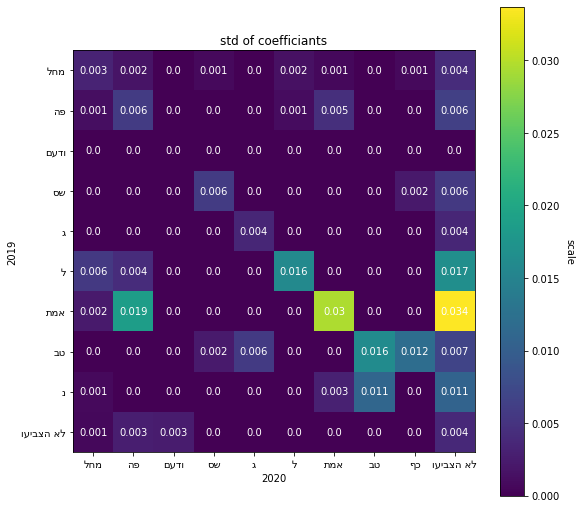

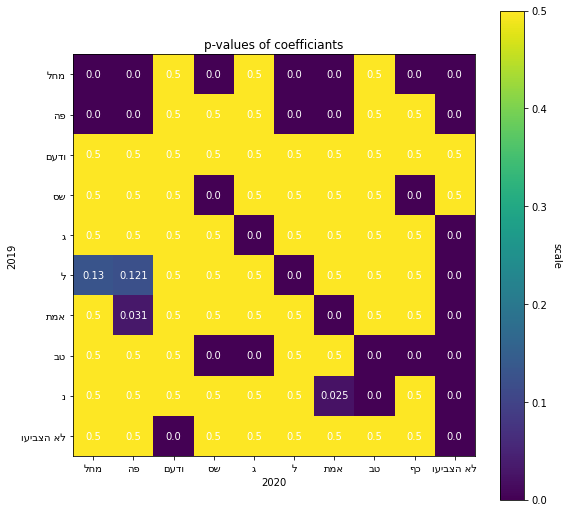

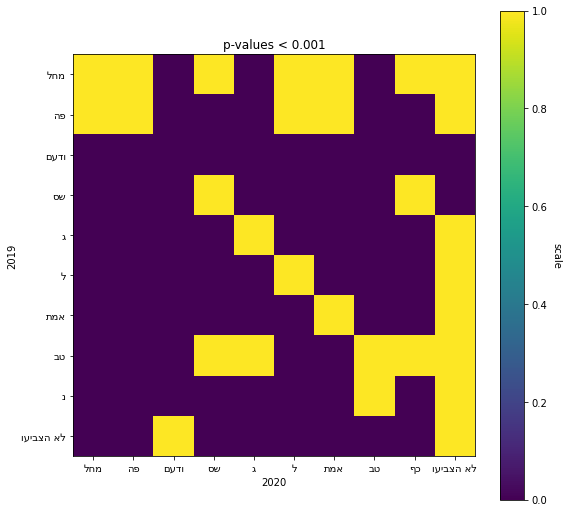

In [122]:
# Compute p-values using bootstrap
p_val_boot, t_stat_boot, std_boot = compute_coef_pvals(top_ap_sep.values, top_sep_ap.values, True, True, 100)  

show_mat_heat_map(std_boot.T, par_dict19b, par_dict19a, 'std of coefficiants')
show_mat_heat_map(p_val_boot.T, par_dict19b, par_dict19a, 'p-values of coefficiants')
show_mat_heat_map((p_val_boot<0.001).T,par_dict19b, par_dict19a, 'p-values < 0.001', True)

מובהקות מעברים בין ספטמבר 2019 למרץ 2020

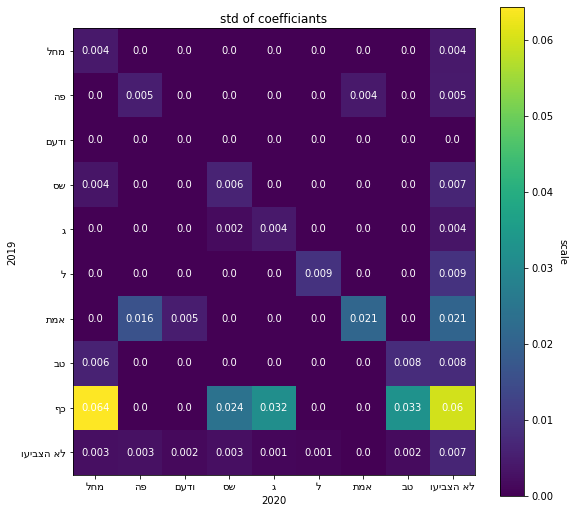

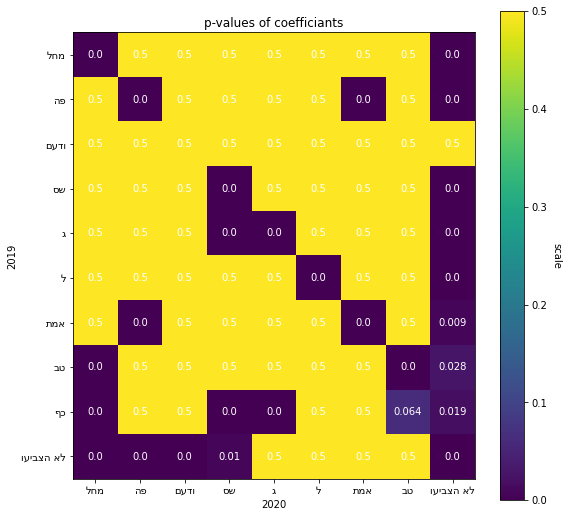

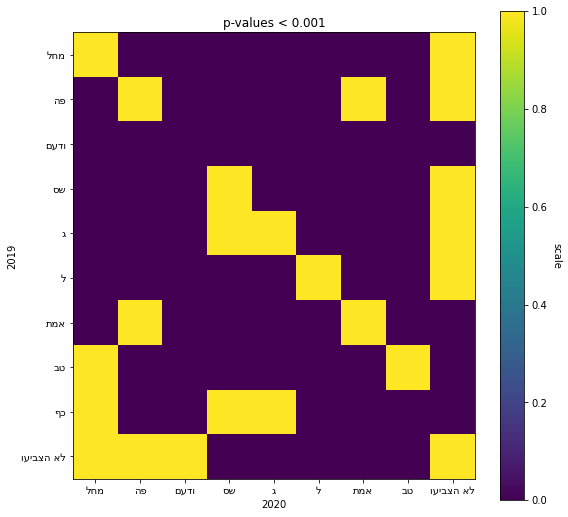

In [123]:
# Compute p-values using bootstrap
p_val_boot, t_stat_boot, std_boot = compute_coef_pvals(top_sep_mar.values, top_mar_sep.values, True, True, 100)  

show_mat_heat_map(std_boot.T, par_dict20, par_dict19b, 'std of coefficiants')
show_mat_heat_map(p_val_boot.T, par_dict20, par_dict19b, 'p-values of coefficiants')
show_mat_heat_map((p_val_boot<0.001).T, par_dict20, par_dict19b, 'p-values < 0.001', True)

מובהקות מעברים בין אפריל 2019 למרץ 2020

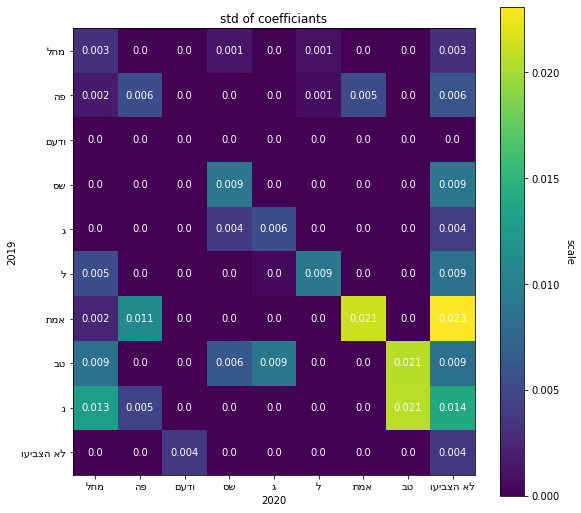

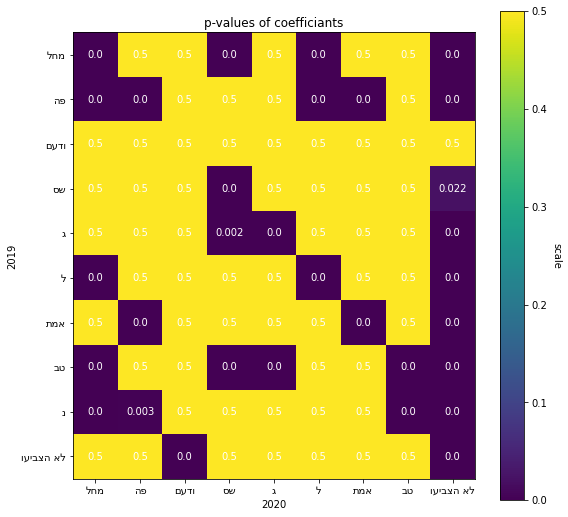

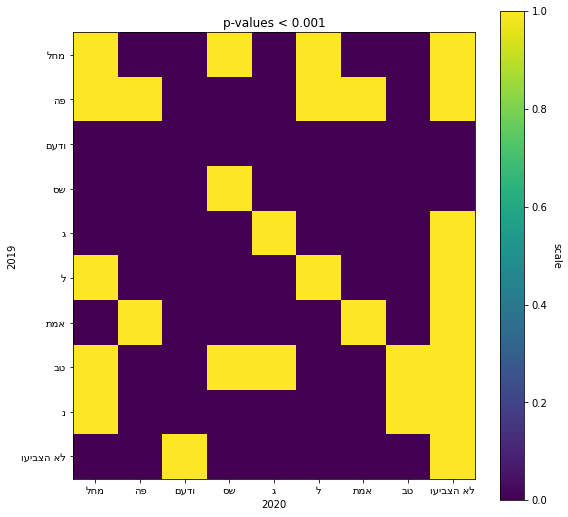

In [124]:
# Compute p-values using bootstrap
p_val_boot, t_stat_boot, std_boot = compute_coef_pvals(top_ap_mar.values, top_mar_ap.values, True, True, 100)  

show_mat_heat_map(std_boot.T, par_dict20, par_dict19a, 'std of coefficiants')
show_mat_heat_map(p_val_boot.T, par_dict20, par_dict19a, 'p-values of coefficiants')
show_mat_heat_map((p_val_boot<0.001).T,par_dict20, par_dict19a, 'p-values < 0.001', True)

# **ח.זיהוי קלפיות חשודות**

In [125]:
df_2019a_ballot_raw = df_2019a_ballot_raw.rename(columns =  {'מספר קלפי' : 'קלפי'})
b2019a = df_2019a_ballot_raw[["טב","נ","קלפי","שם ישוב","כשרים"]]
b2019b = df_2019b_ballot_raw[["טב","קלפי","שם ישוב","כשרים"]]
b2020 = df_2020_ballot_raw[["טב","קלפי","שם ישוב","כשרים"]]
b2019a["טב"] = b2019a["טב"] + b2019a["נ"]

In [126]:
all_merge = pd.merge(b2019a, b2019b, how='inner', on= ["סמל ישוב", "קלפי"] )
all_merge = pd.merge(all_merge, b2020, how='inner',on= ["סמל ישוב", "קלפי"])

In [127]:
all_merge["diff ap-sep"] = all_merge["טב_y"]/all_merge["כשרים_y"] - all_merge["טב_x"]/all_merge["כשרים_x"]
all_merge["diff sep-mar"] = all_merge["טב"]/all_merge["כשרים"] - all_merge["טב_y"]/all_merge["כשרים_y"]
all_merge["diff ap-mar"] = all_merge["טב"]/all_merge["כשרים"] - all_merge["טב_x"]/all_merge["כשרים_x"]


all_merge["abs_diff ap-sep"] =abs(all_merge["diff ap-sep"])
all_merge["abs_diff sep-mar"] = abs(all_merge["diff sep-mar"])
all_merge["abs_diff ap-mar"] = abs(all_merge["diff ap-mar"])

In [128]:
all_merge.sort_values(ascending=False,by='abs_diff sep-mar').head(10)[["שם ישוב","קלפי","diff sep-mar"]]

,שם ישוב,קלפי,diff sep-mar
סמל ישוב,,,
1296,כסראסמיע,8.0,-0.279903
4001,בוקעאתא,1.0,0.210526
3824,עמיחי,1.0,0.174688
1296,כסראסמיע,1.0,-0.174277
1296,כסראסמיע,5.0,-0.152868
1371,גני טל,1.0,-0.144715
1282,מירב,1.0,-0.137941
1296,כסראסמיע,9.0,-0.128777
3747,דולב,1.0,-0.124703


In [129]:
all_merge.sort_values(ascending=False,by='abs_diff ap-sep').head(10)[["שם ישוב","קלפי","diff ap-sep"]]

,שם ישוב,קלפי,diff ap-sep
סמל ישוב,,,
212,בית צבי,1.0,-0.666667
3749,יצהר,1.0,-0.583955
3824,עמיחי,1.0,-0.563419
1366,נווה,1.0,-0.543763
696,כפר חבד,5.0,-0.537711
696,כפר חבד,1.0,-0.535996
696,כפר חבד,4.0,-0.503996
8000,צפת,6.0,-0.495517
696,כפר חבד,6.0,-0.454024


In [130]:
all_merge.sort_values(ascending=False,by='abs_diff ap-mar').head(10)[["שם ישוב","קלפי","diff ap-mar"]]

,שם ישוב,קלפי,diff ap-mar
סמל ישוב,,,
212,בית צבי,1.0,-0.636364
696,כפר חבד,5.0,-0.588499
1366,נווה,1.0,-0.584895
696,כפר חבד,1.0,-0.557046
8000,צפת,6.0,-0.540668
696,כפר חבד,4.0,-0.532645
3749,יצהר,1.0,-0.532056
696,כפר חבד,2.0,-0.482844
696,כפר חבד,6.0,-0.467686
